# Construct Frame Classifier

This notebook contains all the necessary code for reading in the image frame data, processing the dataset, using it to train the CNN classifier, plotting the training history, and saving the model. Each individual cell has it's own sequential purpose in this process, and is documented for understanding.

### All the Necessary Imports Needed

* **`os`**: Used for navigating filesystem and collecting the list of file names for dataset processing
* **`matplotlib.pyplot`**: used for plotting the training history for the CNN model
* **`PIL.Image`**: used for reading the image data, converting to grayscale, and resizing the image
* **`pandas`**: used for tabular data representation (depricated)
* **`numpy`**: used for matrix operations and mathematical transformations to dataset such as normalization.
* **`tensorflow`**: the GPU version of tensorflow was used. Untested for CPU version.
* **`tensorflow.keras`**: keras used for management and structure of the neural network
* **`sklearn.model_selection.train_test_split`**: used for partitioning the dataset into train and test sets for evaluating the training and final performance of the model.

In [1]:
# === Necessary Imports === #
import os
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd  # depricated
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

# === Configure GPU (Can Result in "Unknown Error" if Not Done) === #
gpus = tf.config.experimental.list_physical_devices( 'GPU' )
tf.config.experimental.set_memory_growth( gpus[0] , True )

### Extract a List of Data Directories

This will produce a list of all folders within the `dataset` directory. Note: it is expected that there is no other files besides the data subdirectories. We Expect that the name of each subdirectory is the name of the class that its contents represent.

In [2]:
# === List Directory Contents and Cast to Python List === #
directory_list = [ d for d in os.listdir( 'dataset' ) ]
directory_list

['center',
 'near_left',
 'near_right',
 'off_left',
 'off_right',
 'tunnel_left',
 'tunnel_right',
 'wall_left',
 'wall_right']

### Use Directory List to Produce List of All Data Files

Now we will iterate over the the directory list constructed in the previous cell. For each, we will again utilize the `os` package to list the contents of that subdirectory. We cast that result to a list, and append the contents of that list to the main file list, which will contain the list of all data image file names after this cell finishes running. 

In [3]:
# === Initialize Empty List === #
file_list = list( )

# === Iterate Subdirectories and Append their Files to the List === #
for d in directory_list:
    files      = [ 'dataset/{}/{}'.format( d , f ) for f in os.listdir( 'dataset/{}'.format( d ) ) ]
    file_list += files
    
# === Show Success by Printing First 10 === #
file_list[:10]

['dataset/center/frame0.jpg',
 'dataset/center/frame1.jpg',
 'dataset/center/frame10.jpg',
 'dataset/center/frame100.jpg',
 'dataset/center/frame1000.jpg',
 'dataset/center/frame1001.jpg',
 'dataset/center/frame1002.jpg',
 'dataset/center/frame1003.jpg',
 'dataset/center/frame1004.jpg',
 'dataset/center/frame1005.jpg']

### Extract Image Shape and Desired Resize Shape

In this cell, we temporarily open the first image in the dataset, extract the shape of that image, and resize it according to our desired resize_scale. We set the scale to 10, so we expect the resized images to be 1/10th the original size (rounded down to the nearest pixel).

In [4]:
# === Extract Original Dimensions === #
H , W = np.shape( Image.open( file_list[0] ).convert( 'L' ) )

# === Resize the Dimensions Appropriately === #
resize_scale = 10
H2 , W2      = H//resize_scale , W//resize_scale

# === Logging: Print Original and Resized Dimensions === #
print( 'Original Shape = %d x %d => %d Pixels' % ( H , W , H*W ) )
print( 'Resized Shape = %d x %d => %d Pixels' % ( H2 , W2 , H2*W2 ) )

Original Shape = 640 x 802 => 513280 Pixels
Resized Shape = 64 x 80 => 5120 Pixels


### Reading the Dataset into Memory

This process can take a while, since we transform the dataset as we read it, and the original dataset is a few gigabytes in size. We first define a dictionary used to encode/decode the class names to class numbers. There are ~35,000 images, each originally 640x802 pixels. Each image is processed as it is read. On my machine personally, this process may take a couple minutes, but it does not exceed or approach memory limits.

Next, we construct a numpy array of the expected dimensions to fit the entire dataset. We do this in order to reduce the runtime cost of resizing a numpy array for each data read. Since we know what the dimensions of each image will be (`H2` height and `W2` width), and we know how many images we will be reading (length of `file_list`), since we will be using grayscale, we know exactly how many pixels to use per file and how many files total. This lets us construct the appropriately sized numpy array before reading anything into memory.

Then for each image file in the file list, we open the file, convert to grayscale, transform into the appropriate size, cast to a numpy array, and store in the next available index of our data array we have been populating.

In [5]:
# === Data Class Encoder/Decoder === #
classes = {
    # Class Number to Class Name Decoder
    0:'center',
    1:'near_left',
    2:'near_right',
    3:'off_left',
    4:'off_right',
    5:'wall_left',
    6:'wall_right',
    7:'tunnel_left',
    8:'tunnel_right',
    # Class Name to Class Number Encoder
    'center':0,
    'near_left':1,
    'near_right':2,
    'off_left':3,
    'off_right':4,
    'wall_left':5,
    'wall_right':6,
    'tunnel_left':7,
    'tunnel_right':8
}

# === Construct Empty Array of Appropriate Dimensions === #
n_images = len( file_list )
arr      = np.zeros( ( n_images , H2 , W2 ) )
labels   = list( )

# === Iterate Files and Load Appropriately Transformed Image into Memory === #
print( 'Loading Images...' )
for i in range( n_images ):
    
    # === Open, Convert to Grayscale, and Resize === #
    im = Image.open( file_list[i] ).convert( 'L' ).resize( ( W2 , H2 ) )
    
    # === Store Image Data and Class Label === #
    arr[i,:] = np.asarray( im )
    labels.append( classes[ file_list[i].split( '/' )[1] ] )
    
    # === Logging Purposes: Only Print for 1/20th of Images Processed === #
    if ( i + 1 ) % ( n_images//20 ) == 0:
        print( 'Image {}/{} Loaded...'.format( i + 1 , n_images ) )
        
# === Cast Labels List to Numpiy Array for Consistency === #
labels = np.array( labels )

# === Report Completion === #
print( 'Done' )

Loading Images...
Image 1782/35657 Loaded...
Image 3564/35657 Loaded...
Image 5346/35657 Loaded...
Image 7128/35657 Loaded...
Image 8910/35657 Loaded...
Image 10692/35657 Loaded...
Image 12474/35657 Loaded...
Image 14256/35657 Loaded...
Image 16038/35657 Loaded...
Image 17820/35657 Loaded...
Image 19602/35657 Loaded...
Image 21384/35657 Loaded...
Image 23166/35657 Loaded...
Image 24948/35657 Loaded...
Image 26730/35657 Loaded...
Image 28512/35657 Loaded...
Image 30294/35657 Loaded...
Image 32076/35657 Loaded...
Image 33858/35657 Loaded...
Image 35640/35657 Loaded...
Done


### Train-Test Split

Using the function imported from `sklearn.model_selection`, we will partition our dataset into four numpy arrays. The image data used for training, the image data used for testing, and their corresponding labels for each. 

Additionally, we will reshape the training and testing partitions to more appropriately fit the necessary shape for the CNN model in the next few cells. Specifically, adding a fourth dimension (1st = specific image, 2nd = pixel y location, 3rd = pixel x location). The new dimension will be of length 1, and has no impact on the structural integrity of the image data itself.

In [6]:
# === Partition Dataset === #
X_train , X_test , y_train , y_test = train_test_split( arr , labels )

# === Add Extra Empty Dimension === #
X_train = X_train.reshape( X_train.shape[0] , X_train.shape[1] , X_train.shape[2] , 1 )
X_test  = X_test.reshape( X_test.shape[0] , X_test.shape[1] , X_test.shape[2] , 1 )

### CNN Input Layer

Construct the input layer for our model. The shape should be the dimensions of the image, as well as a dimension of 1.

In [7]:
# === Construct the Input Layer === #
conv_input_size  = ( arr[0].shape[0] , arr[0].shape[1] , 1 )
conv_input_layer = keras.Input( conv_input_size , name="conv_input" )   # create input layer

# === Print Layer Information to Show Success === #
print( conv_input_layer )

Tensor("conv_input:0", shape=(None, 64, 80, 1), dtype=float32)


### Construct Hidden and Output Layers

The hidden layers of the CNN are constructed together within this cell. The output layer is also constructed. For the output layer, we produce a mapping to the "certainty" levels for each class that the model was trained on. 

In [8]:
# === 3x3 Convolution Layer/Filter === #
# Output shape = 32
# Kernel size  = 3x3 (3x3 filter)
# Activation   = relu (ReLu activation function)
conv_layer_1 = keras.layers.Conv2D( 32, 
                                    kernel_size=( 3 , 3 ), 
                                    activation="relu",
                                    name="conv_layer_1" )

# === Maxpool Layer to Reduce Dimensionality === #
# Pool Size = 2x2 
maxpool_1 = keras.layers.MaxPooling2D( pool_size=( 2 , 2 ),
                                       name="maxpool_1" )

# === 3x3 Convolutional Layer/Filter === #
# Output Shape = 64
# Kernel size  = 3x3 (3x3 filter)
# Activation   = relu (ReLu activation function)
conv_layer_2 = keras.layers.Conv2D( 64, 
                                    kernel_size=( 3 , 3 ), 
                                    activation="relu",
                                    name="conv_layer_2" )

# === Final Maxpool Layer to Reduce Dimensionality Once More === #
# Pool Size = 2x2
maxpool_2 = keras.layers.MaxPooling2D( pool_size=( 2 , 2 ),
                                       name="maxpool_2" )

# === Flatten the Layers (I'm guessing to flatten for the "dense" output layer) === #
flatten = keras.layers.Flatten( )

# === Add a Dense Output Layer to Map the Above to one of 9 classes === #
conv_class_layer = keras.layers.Dense( 9 , activation="softmax" )

### Create List of CNN Layers

This list allows us to better visualize the structure of the NN model, as well as be used for input into the keras model to construct the NN from the given layers.

In [9]:
# === List of the Layers Made in the Last Cell === #
conv_layers = [conv_input_layer,
               conv_layer_1,
               maxpool_1,
               conv_layer_2,
               maxpool_2,
               flatten,
               conv_class_layer]

### Construct the Model

Using our constructed layers from the previous cells above, we will construct a Keras model of our desired structure. To show that the model structure was created correctly, we will print the results of Keras's built-in summary function for our model.

In [10]:
# === Construct and Summarize Keras Model We Defined === #
conv_model = keras.Sequential( layers=conv_layers )
conv_model.summary( )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer_1 (Conv2D)        (None, 62, 78, 32)        320       
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 31, 39, 32)        0         
_________________________________________________________________
conv_layer_2 (Conv2D)        (None, 29, 37, 64)        18496     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 14, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16128)             0         
_________________________________________________________________
dense (Dense)                (None, 9)                 145161    
Total params: 163,977
Trainable params: 163,977
Non-trainable params: 0
__________________________________________________

### Compile the Model

Now that the model structure has been determined and constructed, we will compile the mdoel. For our purposes, we will use Sparse Categorical Crossentropy for our loss function, the adam optimizer, and Accuracy as our performance metric.

In [11]:
# === Compile the Model === #
conv_model.compile( loss      = "sparse_categorical_crossentropy", 
                    optimizer = "adam", 
                    metrics   = ["accuracy"] )

### Train the Model

Using our training and testing datasets, constructed earlier, we will train our model. Since the machine being used is powerful enough to handle it with relative efficiency on a GPU, the model will be trained for 100 epochs using a batch size of 128. Trained on an NVIDIA RTX 2070, each epoch took slightly longer than 3 seconds. The entire training process took between 5 and 6 minutes. It is untested how performance compares with the CPU version of tensorflow, or performance on lower-power machines.

In [12]:
# === Train the Model to Our Data for 25 Epochs === #
conv_hist = conv_model.fit( X_train,
                            y_train,
                            batch_size=128,
                            epochs=100,
                            validation_data=( X_test , y_test ) )

# === Extract History Values for Later Plotting === #
conv_hist_dict = conv_hist.history

Train on 26742 samples, validate on 8915 samples
Epoch 1/100
26742/26742 [==============================] - 6s 216us/sample - loss: 2.5521 - accuracy: 0.8498 - val_loss: 0.0947 - val_accuracy: 0.9703
Epoch 2/100
26742/26742 [==============================] - 3s 104us/sample - loss: 0.0621 - accuracy: 0.9792 - val_loss: 0.0623 - val_accuracy: 0.9799
Epoch 3/100
26742/26742 [==============================] - 3s 104us/sample - loss: 0.0311 - accuracy: 0.9898 - val_loss: 0.0437 - val_accuracy: 0.9853
Epoch 4/100
26742/26742 [==============================] - 3s 103us/sample - loss: 0.0172 - accuracy: 0.9948 - val_loss: 0.0406 - val_accuracy: 0.9880
Epoch 5/100
26742/26742 [==============================] - 3s 105us/sample - loss: 0.0122 - accuracy: 0.9966 - val_loss: 0.0308 - val_accuracy: 0.9920
Epoch 6/100
26742/26742 [==============================] - 3s 104us/sample - loss: 0.0102 - accuracy: 0.9969 - val_loss: 0.0289 - val_accuracy: 0.9917
Epoch 7/100
26742/26742 [====================

26742/26742 [==============================] - 3s 106us/sample - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0202 - val_accuracy: 0.9958
Epoch 55/100
26742/26742 [==============================] - 3s 106us/sample - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0195 - val_accuracy: 0.9958
Epoch 56/100
26742/26742 [==============================] - 3s 105us/sample - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.0202 - val_accuracy: 0.9958
Epoch 57/100
26742/26742 [==============================] - 3s 106us/sample - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0203 - val_accuracy: 0.9960
Epoch 58/100
26742/26742 [==============================] - 3s 106us/sample - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.0200 - val_accuracy: 0.9958
Epoch 59/100
26742/26742 [==============================] - 3s 107us/sample - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0197 - val_accuracy: 0.9958
Epoch 60/100
26742/26742 [==============================] - 3s 106us/sample - loss: 0.0018 - accuracy

### Plot Model Training and Validation Accuracies

To have a better visualization of our model's performance, we will plot both the training and validation accuracies on the same set of axes. Note that there shouldn't be much chance of overfitting, since the number of epochs and the size of the batch are low compared to the nubmer of trainable parameters.

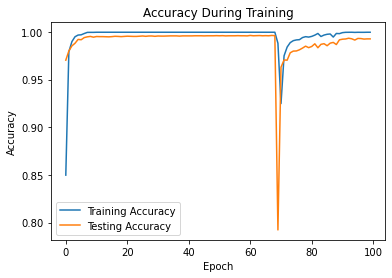

In [13]:
# === Plot the Data === #
plt.plot( conv_hist_dict['accuracy']     , label='Training Accuracy' )
plt.plot( conv_hist_dict['val_accuracy'] , label='Testing Accuracy'  )

# === Label the Chart === #
plt.xlabel( 'Epoch' )
plt.ylabel( 'Accuracy' )
plt.title( 'Accuracy During Training' )
plt.legend( )

# === Display the Chart === #
plt.show( )

### Saving the Model

Now we will save the model as a .h5 file. You can replace the `'your_model_name.h5'` with any file name you desire, as long as the file format can be later read by keras for model loading in other applications. 

In [14]:
tf.keras.models.save_model(
    conv_model,
    'your_model_name.h5',
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

### Testing Model Performance

To demonstrate the effectiveness of the model, we will select a random image from the training dataset, plot it with matplotlib, and use the model's predicted label as the title.

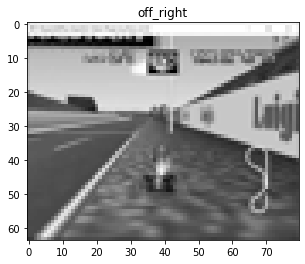

In [19]:
# === Select Demonstration Image === #
test_idx = np.random.choice( range( len( X_test ) ) )

# === Determine Classification === #
weights = conv_model.predict(X_test[test_idx].reshape(1,X_test[test_idx].shape[0], X_test[test_idx].shape[1], X_test[0].shape[2]))
classification = classes[np.argmax(weights)]

# === Plot the Image with Class as Title === #
plt.figure()
plt.imshow(X_test[test_idx].reshape(X_test[test_idx].shape[0], X_test[test_idx].shape[1]),cmap='gray')
plt.title(classification)
plt.show()

### Dataset Information

Report on the size of the dataset for use in the report later.

In [20]:
print('Number of Training Items: {}'.format(len(y_train)))
print('Number of Testing Items:  {}'.format(len(y_test)))
print('Full Dataset Contained {} Frames'.format(len(arr)))

Number of Training Items: 26742
Number of Testing Items:  8915
Full Dataset Contained 35657 Frames
